![](img/330-banner.png)

# Lecture 17: Multi-class classification and introduction to computer vision 

UBC 2022 Summer

Instructor: Mehrdad Oveisi

## Imports

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

## Learning objectives

- Apply classifiers to multi-class classification algorithms.
- Explain the role of neural networks in machine learning, and the pros/cons of using them.
- Explain why the methods we've learned previously would not be effective on image data.
- Apply pre-trained neural networks to classification and regression problems.
- Utilize pre-trained networks as feature extractors and combine them with models we've learned previously.

## Recap

### True/False questions

1. Word representation created by term-term co-occurrence matrix are long and sparse whereas the ones created by Word2Vec are short and dense.
1. It's possible to use word representations for text classification instead of bag-of-words representation.

### Questions for discussion 

- Given the following table, which word pair is more similar in terms of dot product: (word 1, word 2) or (word 1, word 3)?

![](img/similarity_question.png)

<!-- <img src="img/similarity_question.png" width="500" height="500"> -->

### True/False questions

1. The topic model approach we used in the last lecture, Latent Dirichlet Allocation (LDA), is an unsupervised approach. 
1. In an LDA topic model, the same word can be associated with two different topics with high probability.
1. If I train a topic model on a large collection of news articles with K = 10, I would get 10 topic labels (e.g., sports, culture, politics, finance) as output. 

## Multi-class, meta-strategies

- So far we have been talking about binary classification 
- Can we use these classifiers when there are more than two classes? 
    - ["ImageNet" computer vision competition](http://www.image-net.org/challenges/LSVRC/), for example, has [1000 classes](https://image-net.org/challenges/LSVRC/2017/browse-synsets.php)
- Can we use decision trees or KNNs for multi-class classification?
- What about logistic regression and Linear SVMs?

- Many linear classification models don't extend naturally to the multiclass case. 
- A common technique is to reduce multiclass classication into several instances of binary classification problems. 
- Two kind of "hacky" ways to reduce multi-class classification into binary classification:  
    - the one-vs.-rest approach
    - the one-vs.-one approach 

***Note***
There is also a **multinomial** logistic regression also known as **the maxent classifier**. This is different than the above multi-class meta strategies. More on this in DSCI 573.

### One vs. Rest approach

- 1v{2,3}, 2v{1,3}, 3v{1,2}
- Learn a binary model for each class which tries to separate that class from all of the other classes.
- If you have $k$ classes, it'll train $k$ binary classifiers, one for each class. 
- Trained on imbalanced datasets containing all examples.
- Given a test point, get scores from all binary classifiers (e.g., raw scores for logistic regression). 

### One Vs. Rest prediction

- The classifier which has the highest score for this class "**wins**" and that's going to be the prediction for this class. 

- Since we have one binary classifier per class, for each class, we have coefficients per feature and an intercept. 

Let's create some synthetic data with two features and three classes. 

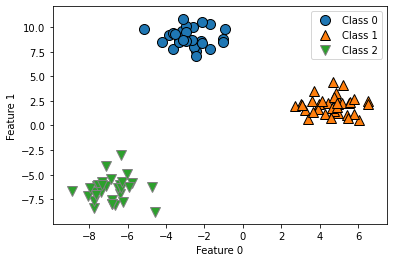

In [2]:
import mglearn
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=3, n_samples=120, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1", "Class 2"]);

In [3]:
lr = LogisticRegression(max_iter=2000, multi_class="ovr")
lr.fit(X_train, y_train)
print("Coefficient shape: ", lr.coef_.shape)
print("Intercept shape: ", lr.intercept_.shape)

Coefficient shape:  (3, 2)
Intercept shape:  (3,)


In [4]:
pd.DataFrame(
    lr.coef_, columns=['Feature 1', 'Feature 2']).assign(Intercept=lr.intercept_)

,Feature 1,Feature 2,Intercept
0,-0.651233,1.053612,-5.426267
1,1.354180,-0.286475,0.216166
2,-0.633207,-0.725136,-2.469413


- This learns three binary linear models.
- So we have coefficients for two features for each of these three linear models. 
- Also we have three intercepts, one for each class. 

[Code credit](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch02.html#linear-models)

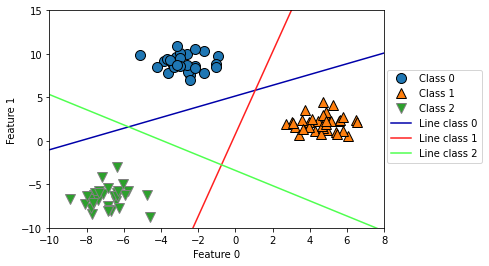

In [5]:
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
line_x = np.linspace(-15, 15)
for coef, intercept, color in zip(lr.coef_, lr.intercept_, mglearn.cm3.colors):
    line_y = -(line_x * coef[0] + intercept) / coef[1]
    plt.plot(line_x, line_y, c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(
    ["Class 0", "Class 1", "Class 2",
     "Line class 0", "Line class 1", "Line class 2"],
    loc=(1.01, 0.3),
);

In [6]:
def plot_test_points():
    test_points = [(-4.0, 12), (-2, 0.0), (-8, 3.0), (4, 8.5)]
    for x, y in test_points:
        plt.plot(x, y, "k*", markersize=16)

- How would you classify these `test_points`?
    - Pick the class with the **highest value** for the classification formula. 

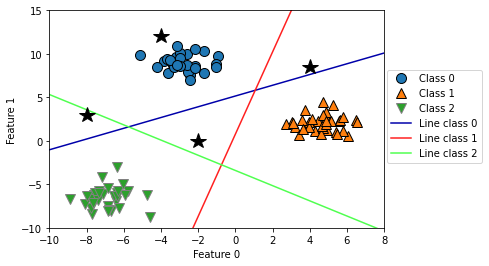

In [7]:
# You don't have to understand the code.
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
line_x = np.linspace(-15, 15)
for coef, intercept, color in zip(lr.coef_, lr.intercept_, mglearn.cm3.colors):
    line_y = -(line_x * coef[0] + intercept) / coef[1]
    plt.plot(line_x, line_y, c=color)
plot_test_points()
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(
    ["Class 0", "Class 1", "Class 2", 
     "Line class 0", "Line class 1", "Line class 2"],
    loc=(1.01, 0.3),
);

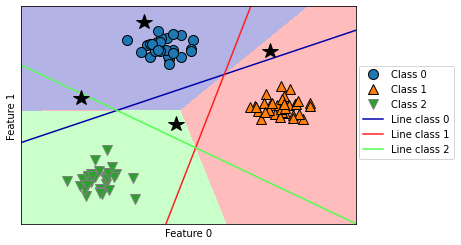

In [8]:
# You don't have to understand the code below.
mglearn.plots.plot_2d_classification(lr, X_train, fill=True, alpha=0.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
line_x = np.linspace(-15, 15)
for coef, intercept, color in zip(lr.coef_, lr.intercept_, mglearn.cm3.colors):
    line_y = -(line_x * coef[0] + intercept) / coef[1]
    plt.plot(line_x, line_y, c=color)
plot_test_points()
plt.legend(
    ["Class 0", "Class 1", "Class 2", 
     "Line class 0", "Line class 1", "Line class 2"],
    loc=(1.01, 0.3),
)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

### One Vs. One approach 

- Build a binary model for each pair of classes.
- 1v2, 1v3, 2v3
- For $k$ classes, it trains $\frac{k \times (k-1)}{2}$ binary classifiers
- Trained on relatively balanced subsets

### One Vs. One prediction

- Apply all of the classifiers on the test example.
- Count how often each class was predicted.  
- Predict the class with most **votes**. 

### Using OneVsRest and OneVsOne as wrappers

- You can use these strategies as meta-strategies for any binary classifiers. 
    - [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)
    - [`OneVsOneClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html)

- When do we use  `OneVsRestClassifier` or `OneVsOneClassifier`?
- It's not that likely for you to need `OneVsRestClassifier` or `OneVsOneClassifier` because most of the methods you'll use will have native multi-class support. 
- However, it's good to know in case you ever need to extend a binary classifier (perhaps one you've implemented on your own).

<br>

Let's examine the **time taken** by OneVsRestClassifier and OneVsOneClassifier.

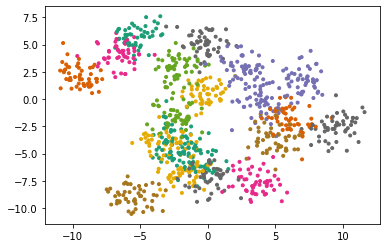

In [9]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

# generate blobs with fixed random generator
X_multi, y_multi = make_blobs(n_samples=1000, centers=20, random_state=300)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi
)

plt.scatter(*X_multi.T, c=y_multi, marker=".", cmap="Dark2");

In [10]:
model = OneVsOneClassifier(LogisticRegression())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVO wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

930 ms ± 201 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
With OVO wrapper
0.808
0.748


In [11]:
model = OneVsRestClassifier(LogisticRegression())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVR wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

362 ms ± 94.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
With OVR wrapper
0.728
0.628


- As expected OVO takes more time compared to OVR.
- [Here](https://scikit-learn.org/stable/modules/multiclass.html) you will find summary of how `scikit-learn` handles multi-class classification for different classifiers. 

### True/False

1. One-vs.-one strategy uses all the available data when training each binary classifier.
2. For a 100-class classification problem, one-vs.-rest multi-class strategy will create 100 binary classifiers. 

### Multi-class classification on [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus

Let's examine precision, recall, and f1-score of different classes in the [HappyDB: "A Corpus of 100,000 Crowdsourced Happy Moments"](https://www.kaggle.com/ritresearch/happydb).

In [12]:
df = pd.read_csv("data/cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)
sample_df.head()

,wid,reflection_period,original_hm,moment,modified,num_sentence,target,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed afte...,My grandmother start to walk from the bed afte...,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and w...,I picked my daughter up from the airport and w...,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [13]:
sample_df["target"].value_counts()

affection           4810
achievement         4276
bonding             1750
enjoy_the_moment    1514
leisure             1306
nature               252
exercise             217
Name: target, dtype: int64

It's a multiclass classification problem! 

In [14]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train_happy, y_train_happy = train_df["moment"], train_df["target"]
X_test_happy, y_test_happy = test_df["moment"], test_df["target"]

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=2000)
)

In [16]:
pipe_lr.fit(X_train_happy, y_train_happy);

In [17]:
preds = pipe_lr.predict(X_test_happy)[:5]
preds

array(['achievement', 'affection', 'bonding', 'enjoy_the_moment',
       'affection'], dtype=object)

Note that the output of `predict_proba` now contains a probability for each class:

In [18]:
pipe_lr.predict_proba(X_test_happy)[:5]

array([[7.06452307e-01, 3.74990372e-02, 5.65453892e-02, 4.48404513e-02,
        3.05695478e-02, 1.10316043e-01, 1.37772248e-02],
       [4.51072156e-03, 9.89340323e-01, 5.83682148e-04, 3.70785468e-03,
        2.90885880e-04, 6.37026516e-04, 9.29506481e-04],
       [2.13262697e-03, 1.51560025e-02, 9.78843708e-01, 1.36500567e-03,
        1.26026319e-03, 9.41811597e-04, 3.00582288e-04],
       [1.13081120e-01, 9.17845566e-02, 2.38838787e-02, 5.06683802e-01,
        7.30917658e-03, 2.49576657e-01, 7.68080910e-03],
       [7.71874166e-02, 5.53222814e-01, 3.87143050e-02, 8.14784048e-02,
        2.38186758e-02, 2.08421235e-01, 1.71571482e-02]])

In [19]:
pd.DataFrame(pipe_lr.predict_proba(X_test_happy), columns=pipe_lr.classes_).head()

,achievement,affection,bonding,enjoy_the_moment,exercise,leisure,nature
0,0.706452,0.037499,0.056545,0.044840,0.030570,0.110316,0.013777
1,0.004511,0.989340,0.000584,0.003708,0.000291,0.000637,0.000930
2,0.002133,0.015156,0.978844,0.001365,0.001260,0.000942,0.000301
3,0.113081,0.091785,0.023884,0.506684,0.007309,0.249577,0.007681
4,0.077187,0.553223,0.038714,0.081478,0.023819,0.208421,0.017157


And you'll see that each row adds up to 1, as expected:

In [20]:
pipe_lr.predict_proba(X_test_happy).sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

We can also make a confusion matrix:

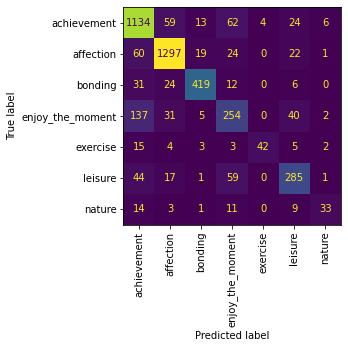

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    pipe_lr,
    X_test_happy,
    y_test_happy,
    values_format="d",
    xticks_rotation="vertical",
    colorbar=False,
);

And print the classification report. 

In [22]:
print(classification_report(y_test_happy, pipe_lr.predict(X_test_happy)))

                  precision    recall  f1-score   support

     achievement       0.79      0.87      0.83      1302
       affection       0.90      0.91      0.91      1423
         bonding       0.91      0.85      0.88       492
enjoy_the_moment       0.60      0.54      0.57       469
        exercise       0.91      0.57      0.70        74
         leisure       0.73      0.70      0.71       407
          nature       0.73      0.46      0.57        71

        accuracy                           0.82      4238
       macro avg       0.80      0.70      0.74      4238
    weighted avg       0.82      0.82      0.81      4238



- Seems like there is a lot of variation in the scores for different classes. 
- The model is performing pretty well on _affection_ class but not that well on _enjoy_the_moment_ and _nature_ classes.  

How are the predictions made? 

In [23]:
predict_probas = pipe_lr.predict_proba(X_test_happy)
df = pd.DataFrame(predict_probas, columns=pipe_lr.classes_)
df.head()

,achievement,affection,bonding,enjoy_the_moment,exercise,leisure,nature
0,0.706452,0.037499,0.056545,0.044840,0.030570,0.110316,0.013777
1,0.004511,0.989340,0.000584,0.003708,0.000291,0.000637,0.000930
2,0.002133,0.015156,0.978844,0.001365,0.001260,0.000942,0.000301
3,0.113081,0.091785,0.023884,0.506684,0.007309,0.249577,0.007681
4,0.077187,0.553223,0.038714,0.081478,0.023819,0.208421,0.017157


In [24]:
df['Winner'] = df.idxmax(axis=1)
df.head()

,achievement,affection,bonding,enjoy_the_moment,exercise,leisure,nature,Winner
0,0.706452,0.037499,0.056545,0.044840,0.030570,0.110316,0.013777,achievement
1,0.004511,0.989340,0.000584,0.003708,0.000291,0.000637,0.000930,affection
2,0.002133,0.015156,0.978844,0.001365,0.001260,0.000942,0.000301,bonding
3,0.113081,0.091785,0.023884,0.506684,0.007309,0.249577,0.007681,enjoy_the_moment
4,0.077187,0.553223,0.038714,0.081478,0.023819,0.208421,0.017157,affection


In [25]:
df['Predict'] = pipe_lr.predict(X_test_happy)
df.head()

,achievement,affection,bonding,enjoy_the_moment,exercise,leisure,nature,Winner,Predict
0,0.706452,0.037499,0.056545,0.044840,0.030570,0.110316,0.013777,achievement,achievement
1,0.004511,0.989340,0.000584,0.003708,0.000291,0.000637,0.000930,affection,affection
2,0.002133,0.015156,0.978844,0.001365,0.001260,0.000942,0.000301,bonding,bonding
3,0.113081,0.091785,0.023884,0.506684,0.007309,0.249577,0.007681,enjoy_the_moment,enjoy_the_moment
4,0.077187,0.553223,0.038714,0.081478,0.023819,0.208421,0.017157,affection,affection


Now, confirm our manual calculation (`Winner`) and auto calculation (`Predict`) are equal on every row:

In [26]:
df['Winner'].equals(df['Predict'])

True

How many coefficients have we learned? 

In [27]:
pipe_lr.named_steps["logisticregression"].coef_.shape

(7, 8060)

- We have one coefficient per feature _per class_. 
- Let's examine them. 

In [28]:
feature_names = pipe_lr.named_steps["countvectorizer"].get_feature_names_out()
lr_coefs = pd.DataFrame(
    data=pipe_lr.named_steps["logisticregression"].coef_.T,
    index=feature_names,
    columns=pipe_lr.classes_,
).sort_values("bonding", ascending=False)
lr_coefs

,achievement,affection,bonding,enjoy_the_moment,exercise,leisure,nature
friend,-1.687508,-0.183475,5.589816,-1.707884,0.330449,-1.769275,-0.572123
friends,-1.304138,0.052716,5.246049,-1.992706,0.328852,-1.559691,-0.771082
roommate,-1.327173,-0.690690,3.418162,-1.138268,-0.078645,-0.070318,-0.113067
coworkers,-0.588489,-0.606159,3.011448,-1.098920,-0.088529,-0.518731,-0.110620
coworker,-0.934815,-0.591283,2.770895,-0.560367,-0.093261,-0.415518,-0.175651
...,...,...,...,...,...,...,...
feelings,0.057263,1.195037,-0.898350,-0.123819,-0.103988,-0.093035,-0.033108
jogging,-0.046356,-0.319891,-0.909223,-0.098751,1.521339,-0.130397,-0.016721
telling,-0.436985,0.870927,-1.070989,0.694236,-0.066820,0.038828,-0.029198
drive,-0.150849,0.584471,-1.184907,0.891981,-0.239564,-0.453334,0.552202


The interpretation is a feature importance for predicting a certain class. For example:

In [29]:
lr_coefs.loc["friend"]

achievement        -1.687508
affection          -0.183475
bonding             5.589816
enjoy_the_moment   -1.707884
exercise            0.330449
leisure            -1.769275
nature             -0.572123
Name: friend, dtype: float64

In [30]:
lr_coefs.loc["friend"].idxmax()

'bonding'

- This means that if the value for the feature "friend" is bigger, you are more likely to predict class "bonding". 

- If you want a **general feature importance irrespective of class**, you could try looking at the sum of the squares of the coefficients, which is what sklearn does:

In [31]:
(lr_coefs ** 2).sum(axis=1).sort_values(ascending=False)

friend       4.061112e+01
friends      3.633081e+01
husband      2.764457e+01
wife         2.542290e+01
son          2.361040e+01
                 ...     
passport     8.849890e-12
rang         8.849890e-12
postman      8.849890e-12
curiosity    8.849890e-12
itching      8.849890e-12
Length: 8060, dtype: float64

In [32]:
?LogisticRegression

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

- We can see that there's a `multi_class` parameter, that can be set to `'ovr'` or `'multinomial'`, or you can have it automatically choose between the two, which is the default.
  - In CPSC 340 we discuss in detail the difference between these two approaches.
  - In CPSC 340 we make an argument for preferring `'multinomial'`, but in short it doesn't matter which one you choose.

## Break (5 min)

![](img/eva-coffee.png)

## Intro to computer vision

- [Computer vision](https://en.wikipedia.org/wiki/Computer_vision) refers to understanding images/videos, usually using ML/AI. 
- Computer vision has many tasks of interest:
  - image classification: is this a cat or a dog?
  - object localization: where are the people in this image?
  - image segmentation: what are the various parts of this image?
  - motion detection: what moved between frames of a video?
  - and much more...
- We will focus on image classification.

## Intro to neural networks

- Very popular these days thanks to **deep learning**. 
- Neural networks apply a sequence of transformations on your input data.
- At a very high level you can think of them as `Pipelines` in `sklearn`. 
- A neural network is a model that's sort of like its own pipeline
  - It involves a series of transformations ("layers") internally. 
  - The output is the prediction.

![](img/pipeline.png)

<!-- <img src='./img/pipeline.png' width="800"> -->
    
[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

- They can be viewed a **generalization of linear models** where we apply a series of transformations. 
- Here is graphical representation of logistic regression model. 
    - We have 4 features: x[0], x[1], x[2], x[3]

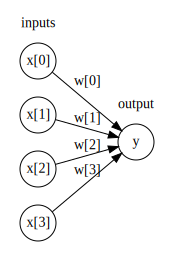

In [33]:
import mglearn

display(mglearn.plots.plot_logistic_regression_graph())

- Below we are adding one "layer" of transformations in between features and the target. 
- We are repeating the the process of computing the weighted sum multiple times.  
- The **hidden units** (e.g., h[1], h[2], ...) represent the intermediate processing steps. 

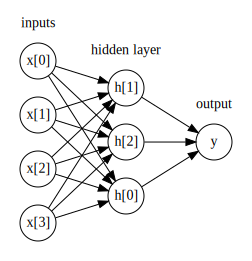

In [34]:
display(mglearn.plots.plot_single_hidden_layer_graph())

- Now we are adding one more layer of transformations. 

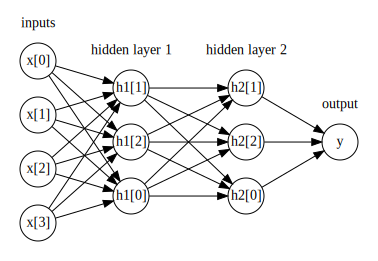

In [35]:
display(mglearn.plots.plot_two_hidden_layer_graph())

- Important question: how many features before/after transformation.
  - e.g. scaling doesn't change the number of features
  - OHE increases the number of features
- With a neural net, you specify the number of features after each transformation.
  - In the above, it goes from 4 to 3 to 3 to 1.

- To make them really powerful compared to the linear models, we apply a non-linear function to the weighted sum for each hidden node. 

### Terminology

- Neural network = neural net
- Deep learning ~ using neural networks

### Why neural networks?

- They can learn very complex functions.
  - The fundamental tradeoff is primarily controlled by the **number of layers** and **layer sizes**.
  - More layers / bigger layers --> more complex model.
  - You can generally get a model that will not underfit. 

### Why neural networks?

- They work really well for structured data:
  - 1D sequence, e.g. timeseries, language
  - 2D image
  - 3D image or video
- They've had some incredible successes in the last 10 years.
- Transfer learning (coming later today) is really useful.  

### Why not neural networks?

- Often they require a lot of data.
- They require a lot of compute time, and, to be faster, specialized hardware called [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit).
- They have huge numbers of hyperparameters, which are a huge pain to tune.
  - Think of each layer having hyperparameters, plus some overall hyperparameters.
  - Being slow compounds this problem.
- They are not interpretable.

### Why not neural networks?

- When you call `fit`, you are not guaranteed to get the optimal.
  - There are now a bunch of hyperparameters specific to `fit`, rather than the model.
  - You never really know if `fit` was successful or not.
  - You never really know if you should have run `fit` for longer.
- I don't recommend training them on your own without further training
  - Take CPSC 340 and other courses if you're interested.
  - I'll show you some ways to use neural networks **without calling `fit`**.

### Deep learning software

- scikit-learn has [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) but they aren't very flexible.
  - In general you'll want to leave the scikit-learn ecosystem when using neural networks.
  - Fun fact: these classes were contributed to scikit-learn by a UBC graduate student.
- There's been a lot of deep learning software out there.

- The current big players are:

1. [TensorFlow](https://www.tensorflow.org)
2. [PyTorch](http://pytorch.org)

- Both are heavily used in industry.
- If interested, see [comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).

## Neural networks on image data

In [36]:
import matplotlib as mpl
from sklearn.datasets import fetch_lfw_people

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["image.cmap"] = "gray"

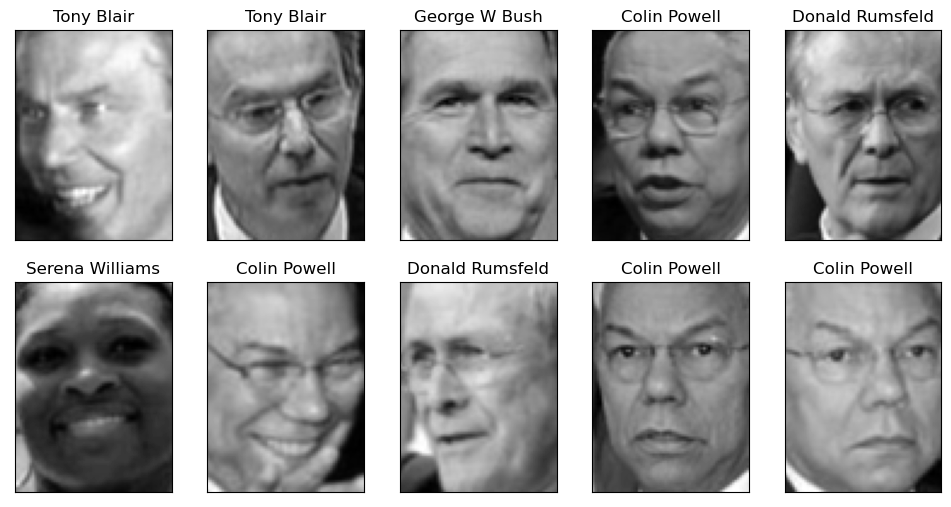

In [37]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=40, resize=0.7)

fig, axes = plt.subplots(2, 5, figsize=(12, 6), subplot_kw={"xticks": (), "yticks": ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [38]:
image_shape = people.images[0].shape
print("people.images.shape: {}".format(people.images.shape))
print("people.data.shape: {}".format(people.data.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (1867, 87, 65)
people.data.shape: (1867, 5655)
Number of classes: 19


There are 1,560 images stored as arrays of 5655 pixels (87 by 65), of 19 different people:

In [39]:
# count how often each target appears
counts = np.bincount(people.target)
df = pd.DataFrame(counts, columns=["count"], index=people.target_names)
df.sort_values("count", ascending=False)

,count
George W Bush,530
Colin Powell,236
Tony Blair,144
Donald Rumsfeld,121
Gerhard Schroeder,109
Ariel Sharon,77
Hugo Chavez,71
Junichiro Koizumi,60
Jean Chretien,55
John Ashcroft,53


Let's make the data less skewed by taking only 20 images of each person.

In [40]:
people.target.shape

(1867,)

In [41]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:20]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

In [42]:
X_people.shape, people.data.shape, y_people.shape, people.target.shape

((380, 5655), (1867, 5655), (380,), (1867,))

In [43]:
20*19, 87*65  # 20 images of 19 people, each having 5655 pixels

(380, 5655)

In [44]:
# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.0

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, random_state=123
)

In [46]:
X_train

array([[0.8156863 , 0.80653596, 0.7908497 , ..., 0.751634  , 0.87058824,
        0.8366013 ],
       [0.13725491, 0.13464051, 0.13202615, ..., 0.21045752, 0.20915033,
        0.20653595],
       [0.44183007, 0.49019608, 0.5555556 , ..., 0.9843137 , 0.98169935,
        0.9764706 ],
       ...,
       [0.8352941 , 0.8405229 , 0.8392157 , ..., 0.66928107, 0.4248366 ,
        0.47843137],
       [0.6261438 , 0.6562091 , 0.654902  , ..., 0.11895425, 0.1254902 ,
        0.13986929],
       [0.16470589, 0.16601306, 0.16601306, ..., 0.6326797 , 0.6183007 ,
        0.60130715]], dtype=float32)

Now the data is in this tabular format that we are used to. 
Now we can use our usual classification methods. 

In [47]:
lr = LogisticRegression(max_iter=4000)
lr.fit(X_train, y_train);

In [48]:
lr.score(X_train, y_train)

1.0

In [49]:
lr.score(X_test, y_test)

0.4842105263157895

We are getting very poor test results :(

- Why flattening images is a bad idea?
  - By "flattening" the image we throw away useful information.
- What the computer sees for each image:

In [50]:
X_train[0]

array([0.8156863 , 0.80653596, 0.7908497 , ..., 0.751634  , 0.87058824,
       0.8366013 ], dtype=float32)

- Hard to classify this!
- [Convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) can take in images without flattening them. 
  - We won't cover CNNs here, but they are in CPSC 340.

<br><br>

## Transfer learning

- In practice, very few people train an entire CNN from scratch because it requires a large dataset, powerful computers, and a huge amount of human effort to train the model. 
- Instead, a common practice is to download a pre-trained model and fine tune it for your task.   
- This is called **transfer learning**. 
- Transfer learning is one of the most common techniques used in the context of computer vision and natural language processing.
    - In the last lecture we used pre-trained embeddings to train create text representation. 

### Using pre-trained models out-of-the-box 

Recall this example from a while back:

In [51]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16

In [52]:
def classify_image(img, topn=4):
    clf = vgg16(pretrained=True)  # Loading the pre-trained model
    preprocess = transforms.Compose(
        [
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )  # Defining a preprocessor to transform a given image so that it's suitable to to pass for prediction

    with open("data/imagenet_classes.txt") as f:
        classes = [line.strip() for line in f.readlines()]

    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)
    clf.eval()
    output = clf(batch_t)
    _, indices = torch.sort(output, descending=True)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    d = {
        "Class": [classes[idx] for idx in indices[0][:topn]],
        "Probability score": [
            np.round(probabilities[0, idx].item(), 3) for idx in indices[0][:topn]
        ],
    }
    df = pd.DataFrame(d, columns=["Class", "Probability score"])
    return df

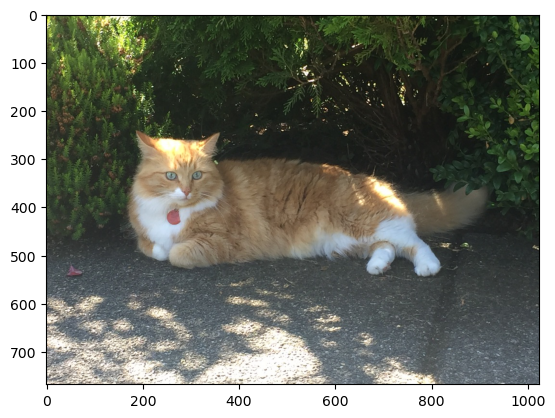

                         Class  Probability score
                     tiger cat              0.357
              tabby, tabby cat              0.207
               lynx, catamount              0.049
Pembroke, Pembroke Welsh corgi              0.046
--------------------------------------------------------------


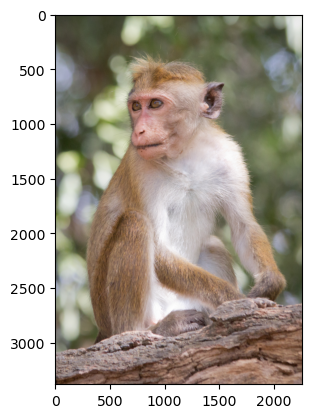

                                   Class  Probability score
                                 macaque              0.714
patas, hussar monkey, Erythrocebus patas              0.122
      proboscis monkey, Nasalis larvatus              0.098
                   guenon, guenon monkey              0.017
--------------------------------------------------------------


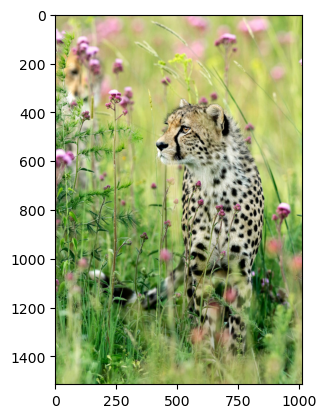

                                     Class  Probability score
         cheetah, chetah, Acinonyx jubatus              0.982
                  leopard, Panthera pardus              0.012
jaguar, panther, Panthera onca, Felis onca              0.004
       snow leopard, ounce, Panthera uncia              0.001
--------------------------------------------------------------


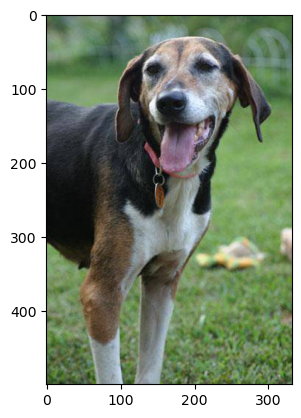

                        Class  Probability score
Walker hound, Walker foxhound              0.577
                  EntleBucher              0.089
             English foxhound              0.086
                       beagle              0.063
--------------------------------------------------------------


In [53]:
# Predict labels with associated probabilities for unseen images
images = glob.glob("data/test_images/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

- We got these predictions without "doing the ML ourselves".
- We are using **pre-trained** `vgg16` model which is available in `torchvision`
- `torchvision` has many such pre-trained models available that have been very successful across a wide range of tasks: AlexNet, VGG, ResNet, Inception, MobileNet, etc.
- Many of these models have been pre-trained on famous datasets like **ImageNet**. 

### ImageNet

- [ImageNet](http://www.image-net.org/) is an image dataset that became a very popular benchmark in the field ~10 years ago. 
- [Wikipedia article](https://en.wikipedia.org/wiki/ImageNet)
- There are 14 million images and 1000 classes.
- Here are some example classes. 

In [54]:
with open("data/imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]
classes[100:110]

['black swan, Cygnus atratus',
 'tusker',
 'echidna, spiny anteater, anteater',
 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 'wallaby, brush kangaroo',
 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'wombat',
 'jellyfish',
 'sea anemone, anemone',
 'brain coral']

Let's see what labels this pre-trained model give us for some unlabeled pictures. Try it with your own pictures!

Images Sources:
  - https://en.wikipedia.org/wiki/Charlie_Chaplin
  - https://en.wikipedia.org/wiki/Mr._Bean

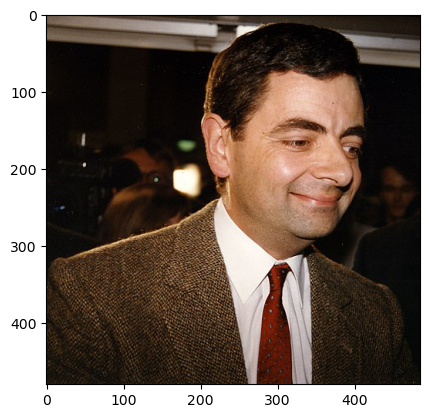

                   Class  Probability score
   suit, suit of clothes              0.417
             Windsor tie              0.253
bow tie, bow-tie, bowtie              0.214
       groom, bridegroom              0.049
--------------------------------------------------------------


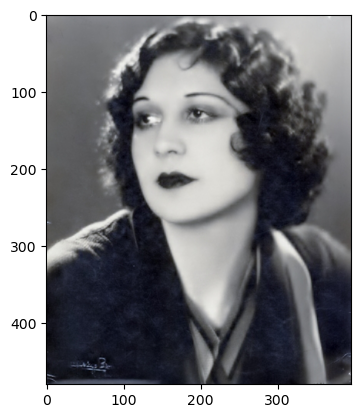

              Class  Probability score
                wig              0.273
           fur coat              0.126
bonnet, poke bonnet              0.090
              cloak              0.058
--------------------------------------------------------------


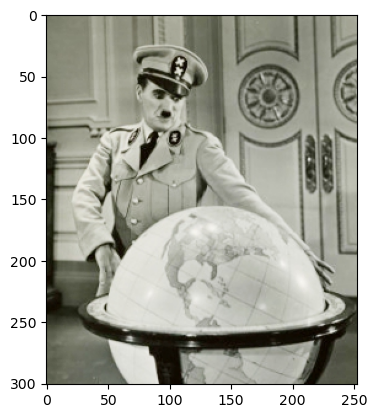

               Class  Probability score
hoopskirt, crinoline              0.277
            vestment              0.055
          steel drum              0.045
   groom, bridegroom              0.029
--------------------------------------------------------------


In [55]:
# Predict labels with associated probabilities for unseen images
images = glob.glob("data/some_people/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

- It's not doing very well here because ImageNet don't have classes for Charlie Chaplin, Lita Grey, Rowan Atkinson.
- Here we are using pre-trained models out-of-the-box. 
- Can we use pre-trained models for our own classification problem with our classes? 
- Yes!! 

## Using pre-trained models as feature extractor

- Here we will use **pre-trained** models to **extract features**.
- We will pass our specific **data through a pre-trained** network to get a **feature vector** for each example in the data. 
- You **train a machine learning classifier** such as logistic regression or random forest using these extracted feature vectors. 

We will use the [Hymenoptera Data](https://download.pytorch.org/tutorial/hymenoptera_data.zip) from a [transfer learning tutorial on PyTorch.org](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [56]:
# Attribution: [Code from PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning)

import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}
data_dir = "data/hymenoptera_data"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

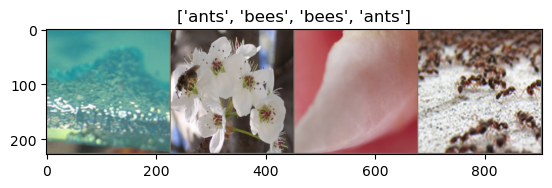

In [57]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [58]:
print(f"Classes: {image_datasets['train'].classes}")
print(
    f"Class count: {[image_datasets['train'].targets.count(i) for i in [0, 1]]}"
)
print(f"Samples:", len(image_datasets["train"]))
print(f"First sample: {image_datasets['train'].samples[0]}")

Classes: ['ants', 'bees']
Class count: [123, 121]
Samples: 244
First sample: ('data/hymenoptera_data/train/ants/0013035.jpg', 0)


`torch.cat` concatenates a given sequence:

In [59]:
# Attribution: [Code adapted from PyTorch docs](https://pytorch.org/docs/stable/generated/torch.cat.html)

x = torch.randn(2, 3)
print("\n", x)
print("\n", torch.cat((x, x, x), dim=0))
print("\n", torch.cat((x, x, x), dim=1))


 tensor([[-0.7062, -0.7539,  0.8162],
        [-1.3644,  0.7026, -1.4110]])

 tensor([[-0.7062, -0.7539,  0.8162],
        [-1.3644,  0.7026, -1.4110],
        [-0.7062, -0.7539,  0.8162],
        [-1.3644,  0.7026, -1.4110],
        [-0.7062, -0.7539,  0.8162],
        [-1.3644,  0.7026, -1.4110]])

 tensor([[-0.7062, -0.7539,  0.8162, -0.7062, -0.7539,  0.8162, -0.7062, -0.7539,
          0.8162],
        [-1.3644,  0.7026, -1.4110, -1.3644,  0.7026, -1.4110, -1.3644,  0.7026,
         -1.4110]])


In [60]:
def get_features(model, train_loader, valid_loader):
    """Extract output of squeezenet model"""

    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_valid = torch.empty((0, 1024))
        y_valid = torch.empty((0))
        for X, y in train_loader:
            Z_train = torch.cat((Z_train, model(X)), dim=0)
            y_train = torch.cat((y_train, y))
        for X, y in valid_loader:
            Z_valid = torch.cat((Z_valid, model(X)), dim=0)
            y_valid = torch.cat((y_valid, y))
    return Z_train.detach(), y_train.detach(), Z_valid.detach(), y_valid.detach()

In [61]:
densenet = models.densenet121(pretrained=True)
densenet.classifier = nn.Identity()  # remove that last "classification" layer

In [62]:
Z_train, y_train, Z_valid, y_valid = get_features(
    densenet, dataloaders["train"], dataloaders["val"]
)

Now we have some extracted features. 

In [63]:
Z_train.shape

torch.Size([244, 1024])

In [64]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
pipe.fit(Z_train, y_train)
pipe.score(Z_train, y_train)

1.0

In [65]:
pipe.score(Z_valid, y_valid)

0.7777777777777778

- This is great accuracy for so little data (we only have 244 examples) and little effort!!!

### TODO

- Compare this to accuracy with flattened images and logistic regression
- Try this out with the Faces dataset. 

## Random cool stuff

- Style transfer: given a "content image" and a "style image", create a new image with the content of one and the style of the other.
  - Here is the [original paper from 2015](https://arxiv.org/pdf/1508.06576.pdf), see Figure 2.
  - Here are more in [this 2016 paper](https://arxiv.org/pdf/1601.04589.pdf); see, e.g. Figures 1 and 7.
  - This has been done for video as well; see [this video from 2016](https://www.youtube.com/watch?v=Khuj4ASldmU).
- [Image captioning](https://cs.stanford.edu/people/karpathy/sfmltalk.pdf): Transfer learning with NLP and vision 
- Colourization: see [this 2016 project](http://iizuka.cs.tsukuba.ac.jp/projects/colorization/en/).
- Inceptionism: let the neural network "make things up"
  - [2015 article](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
  - "Deep dream" [video from 2015](https://www.youtube.com/watch?v=dbQh1I_uvjo).

## Summary

- Multi-class classification refers to classification with >2 classes.
  - Most sklearn classifiers work out of the box.
  - With `LogisticRegression` the situation with the coefficients is a bit funky, we get 1 coefficient per feature per class. 
- Flattening images throws away a lot of useful information (sort of like one-hot encoding on ordinal variable!).
- Neural networks are a flexible class of models.
  - They are hard to train - a lot more on that in CPSC 340.
  - They generally require leaving the sklearn ecosystem to tensorflow or pytorch.
  - They are particular powerful for structured input like images, videos, audio, etc.
- The good news is we can use pre-trained neural networks.
  - This saves us a huge amount of time/cost/effort/resources.
  - We can use these pre-trained networks directly or use them as feature transformers. 
- My general recommendation: don't use deep learning unless there is good reason to.